Use CMap on the LINC1000 data set to rank drugs and other perturbations based on their similarity to the transcriptomic signature of Alzheimer's disease.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import attila_utils

## Sudhir's results

In [2]:
fpath = '../../results/2021-10-04-CMap-discussion/from-sudhir/LINCS1000.results.xlsx'
lincs = pd.read_excel(fpath, 'lincs1000.result')
lincs

,id,Perturbation type,Perturbation type detail,name,description,target,belongs_to,PC3,VCAP,A375,A549,HA1E,HCC515,HT29,MCF7,HEPG2,summary
0,CGS001-2617,KD,Gene-knockdown,GARS,"Aminoacyl tRNA synthetases / Class II, glycyl-...",NaN,Aminoacyl tRNA synthetases class II LOF,-99.66,NaN,-99.94,NaN,-94.59,NaN,46.19,-98.52,-26.25,-99.89
1,CGS001-55657,KD,Gene-knockdown,ZNF692,"Zinc fingers, C2H2-type, zinc finger protein 692",NaN,NaN,-67.11,32.48,-99.66,-50.60,0.00,-99.97,-82.15,NaN,-99.82,-99.89
2,CGS001-9638,KD,Gene-knockdown,FEZ1,fasciculation and elongation protein zeta 1 (z...,NaN,NaN,47.54,79.43,-89.22,-98.91,-98.48,-80.29,NaN,69.55,-99.88,-99.87
3,CGS001-132,KD,Gene-knockdown,ADK,"Adenosine turnover, adenosine kinase",NaN,NaN,-99.87,49.49,-89.48,50.10,-75.77,NaN,-81.86,-98.51,-99.62,-99.76
4,CGS001-79796,KD,Gene-knockdown,ALG9,Dolichyl D-mannosyl phosphate dependent mannos...,NaN,NaN,0.00,NaN,-99.85,-99.45,0.00,NaN,0.00,78.66,-98.27,-99.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8964,CGS001-22827,KD,Gene-knockdown,PUF60,"RNA binding motif (RRM) containing, poly-U bin...",NaN,NaN,0.00,50.14,35.01,99.26,94.10,95.13,98.90,98.86,98.57,99.66
8965,CGS001-10247,KD,Gene-knockdown,HRSP12,heat-responsive protein 12,NaN,NaN,72.96,NaN,98.66,NaN,96.02,-80.00,87.67,98.40,99.29,99.74
8966,CGS001-55746,KD,Gene-knockdown,NUP133,nucleoporin 133kDa,NaN,"Minor histocompatibility antigens LOF, Nucleop...",NaN,45.23,98.71,99.03,99.28,83.13,97.27,99.07,98.75,99.76
8967,CGS001-2101,KD,Gene-knockdown,ESRRA,"Estrogen-related receptors, estrogen-related r...",NaN,NaN,87.47,0.00,99.49,99.79,99.98,NaN,0.00,96.69,96.97,99.84


In [3]:
lincs['name1'] = lincs.name.str.capitalize()
lincs_avg = lincs.groupby('name1').mean()

In [4]:
fpath = '../../results/2021-09-28-drugbank-screen-v1/knowledge-approved-sorted-extended.csv'
dbscreen = pd.read_csv(fpath, index_col='name')
#dbscreen = pd.read_csv(fpath, index_col='drugbank_id')
dbscreen.head()

,drugbank_id,rank,groups,symbol,hgnc_id,d,avg_d_H0,sdev_d_H0,z,p,symbols,n_targets,agora_genes,sum_agora_nomin,avg_agora_nomin,sum_sq_agora_nomin,avg_sq_agora_nomin
name,,,,,,,,,,,,,,,,,
Chlorpheniramine,DB01114,1,approved,HRH1|SLC6A4|SLC6A2|SLC6A3,HGNC:5182|HGNC:11050|HGNC:11048|HGNC:11049,1.000000,1.963500,0.167460,-5.753623,4.367536e-09,"{'SLC6A2', 'SLC6A4', 'SLC6A3', 'HRH1'}",4,set(),0,0.0,0,0.0
Venlafaxine,DB00285,2,approved,SLC6A4|SLC6A2|SLC6A3,HGNC:11050|HGNC:11048|HGNC:11049,1.000000,1.957000,0.183291,-5.221217,8.887556e-08,"{'SLC6A2', 'SLC6A4', 'SLC6A3'}",3,set(),0,0.0,0,0.0
Nomifensine,DB04821,3,approved|withdrawn,SLC6A2|SLC6A3|MAOB|MAOA|MPO|SLC6A4|SLC18A2,HGNC:11048|HGNC:11049|HGNC:6834|HGNC:6833|HGNC...,1.285714,1.998143,0.138566,-5.141426,1.363308e-07,"{'SLC18A2', 'MAOA', 'SLC6A4', 'SLC6A2', 'MAOB'...",7,set(),0,0.0,0,0.0
Duloxetine,DB00476,4,approved,SLC6A4|SLC6A2|SLC6A3,HGNC:11050|HGNC:11048|HGNC:11049,1.000000,1.954000,0.187070,-5.099701,1.700955e-07,"{'SLC6A2', 'SLC6A4', 'SLC6A3'}",3,set(),0,0.0,0,0.0
Desvenlafaxine,DB06700,5,approved|investigational,SLC6A2|SLC6A4|SLC6A3,HGNC:11048|HGNC:11050|HGNC:11049,1.000000,1.951000,0.187792,-5.064126,2.051396e-07,"{'SLC6A2', 'SLC6A4', 'SLC6A3'}",3,set(),0,0.0,0,0.0


Get approved drugs shared by `dbscreen` and `lincs` 

In [5]:
common_drugs = list(set(dbscreen.index).intersection(set(lincs_avg.index)))
common_drugs.sort()
'{} of {} approved DrugBank drugs are in LINCS1000'.format(len(common_drugs), len(dbscreen))

'625 of 1605 approved DrugBank drugs are in LINCS1000'

In [6]:
dbscreen_lincs = pd.concat([dbscreen[['drugbank_id', 'groups', 'symbol', 'rank', 'z', 'p']], lincs_avg], axis=1, join='inner')

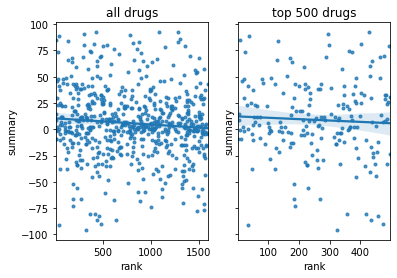

In [7]:
fig, ax = plt.subplots(1, 2, sharey=True)
for df, axi, title in zip([dbscreen_lincs, dbscreen_lincs.loc[dbscreen_lincs['rank'] <= 500]], ax, ['all drugs', 'top 500 drugs']):
    g = sns.regplot(x='rank', y='summary', data=df, fit_reg=True, ax=axi, marker='.')
    axi.set_title(title)

In [8]:
maxrank = dbscreen_lincs['rank'].max()
def get_ols_fit_results(npoints=maxrank, index=None):
    if index is None:
        index = ['top {} drugs'.format(npoints)]
    ols_fit = smf.ols('summary ~ rank', data=dbscreen_lincs.loc[dbscreen_lincs['rank'] <= npoints]).fit()
    df = pd.DataFrame({'beta hat': ols_fit.params['rank'], 'beta stderr': np.sqrt(ols_fit.cov_params().loc['rank', 'rank']), 'pvalue': ols_fit.pvalues['rank']}, index=index)
    return(df)

pd.concat([get_ols_fit_results(index=['all drugs']), get_ols_fit_results(npoints=500)], axis=0)

,beta hat,beta stderr,pvalue
all drugs,-0.005852,0.002795,0.036702
top 500 drugs,-0.013012,0.018065,0.472176


In conclusion:
* There is an expected increase of CMap summary score with higher rank but the increase is only weakly significant
* The weak significance might reflect the fact that only 625 of 1605 approved DrugBank drugs are in LINCS1000

## My query

We use the [query tool](https://clue.io/query) of the CMap portal [clue.io](https://clue.io).  (See an alternative tool [here](https://maayanlab.cloud/l1000cds2/#/index).)  The input data are up and down regulated genes in AD compiled by Sudhir Varma using multiple GEO datasets and an R script calculating a FDR adjusted p value for each gene's differential expression test.  The number of genes in each set corresponds to the upper size limit of gene sets for CMap.

In [9]:
%%bash
cd ~/CTNS/resources/CMap/sudhir-varma/
echo "$(wc -l up.genes.txt) up regulated genes, including:"
head up.genes.txt
echo "$(wc -l down.genes.txt) up regulated genes, including:"
head down.genes.txt

     150 up.genes.txt up regulated genes, including:
NACC2
SNRNP48
FOXF1
CRB2
INHBB
POU3F2
KLHL24
TRPM7
TFEB
NA
     149 down.genes.txt up regulated genes, including:
GALNT17
SCG5
MRPL14
MRPL32
NDRG4
REEP1
SLC1A1
MRPL44
SLC1A6
ASAH2B


## Results

After inspection of the tarball downloaded from [here](https://s3.amazonaws.com/data.clue.io/api/attila.jones@nih.gov/results/Oct_04_2021/my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248/my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248.tar.gz)

In [10]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls

from-sudhir
my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248
my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248.tar.gz
query-1


Note that `query-1` is just a symlink to `my_analysis.sig_queryl1k_tool.615b71e7e8d3bc0017eb9248`

In [11]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls query-1

arfs
down.gmt
gsea
matrices
ncs.gct
query_config.yaml
up.gmt


In [12]:
fpath = '../../results/2021-10-04-CMap-discussion/query-1/ncs.gct'
df = pd.read_csv(fpath, sep='\t', skiprows=[0, 1], na_values='-666')
df

/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,pert_id,pert_iname,cell_iname,pert_type,pert_idose,pert_itime,nsample,ss_ngene,cc_q75,tas,qc_pass,is_hiq,is_ncs_sig,is_exemplar_sig,is_null_sig,moa,target_name,TAG
0,desc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AD transcriptomic signature from Sudhir
1,ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.312...,ADO-TRASTUZUMAB EMTANSINE,ADO-TRASTUZUMAB EMTANSINE,A375,trt_aby,0.31 ug/ml,24 h,3.0,164.0,0.26,0.208804,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.9138
2,ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.3125:3,ADO-TRASTUZUMAB EMTANSINE,ADO-TRASTUZUMAB EMTANSINE,A375,trt_aby,0.31 ug/ml,3 h,3.0,107.0,0.23,0.158630,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0000
3,ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.625:24,ADO-TRASTUZUMAB EMTANSINE,ADO-TRASTUZUMAB EMTANSINE,A375,trt_aby,0.63 ug/ml,24 h,3.0,127.0,0.25,0.180178,1.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0242
4,ABY001_A375_XH:ADO-TRASTUZUMAB_EMTANSINE:0.625:3,ADO-TRASTUZUMAB EMTANSINE,ADO-TRASTUZUMAB EMTANSINE,A375,trt_aby,0.63 ug/ml,3 h,3.0,89.0,0.15,0.116835,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165462,ZTO.XPR001_THP1_408H:GC1:-666,GC1,GC1,THP1,ctl_vector,NaN,408 h,20.0,436.0,0.19,0.291039,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
1165463,ZTO.XPR001_THP1_408H:GC2:-666,GC2,GC2,THP1,ctl_vector,NaN,408 h,20.0,493.0,0.18,0.301224,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0
1165464,ZTO.XPR001_U937_408H:CMAP-000:-666,CMAP-000,UnTrt,U937,ctl_untrt,NaN,408 h,20.0,378.0,0.15,0.240781,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.8771
1165465,ZTO.XPR001_U937_408H:GC1:-666,GC1,GC1,U937,ctl_vector,NaN,408 h,19.0,262.0,0.12,0.179297,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.9141


### arfs

In [13]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls -R query-1/arfs/

TAG
index.txt

query-1/arfs//TAG:
query_result.gct


In [14]:
fpath = '../../results/2021-10-04-CMap-discussion/query-1/arfs/TAG/query_result.gct'
df = pd.read_csv(fpath, sep='\t', skiprows=[0, 1], na_values='-666')
df

/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,pert_id,pert_iname,cell_iname,pert_type,pert_idose,pert_itime,nsample,ss_ngene,cc_q75,...,qc_pass,is_hiq,is_ncs_sig,is_exemplar_sig,is_null_sig,moa,target_name,raw_cs,fdr_q_nlog10,norm_cs
0,desc,na,na,na,na,na,na,na,na,na,...,na,na,na,na,na,na,na,na,na,AD transcriptomic signature from Sudhir
1,KDB008_HEPG2_96H:TRCN0000050256:-666,TRCN0000050256,BPHL,HEPG2,trt_sh,NaN,96 h,4,214,0.55,...,1,0,1,1,0,NaN,NaN,0.5032,3.4284,1.9937
2,KDC006_PC3_96H:TRCN0000059426:-666,TRCN0000059426,ALB,PC3,trt_sh,NaN,96 h,2,171,0.54,...,1,0,1,1,0,NaN,NaN,0.4922,2.8711,1.9501
3,KDB006_HT29_96H:TRCN0000007624:-666,TRCN0000007624,BTG2,HT29,trt_sh,NaN,96 h,4,219,0.53,...,1,0,1,1,0,NaN,NaN,0.4817,2.6436,1.9086
4,PAC021_U2OS_6H:BRD-K55311609-001-01-3:10.1092,BRD-K55311609,BRD-K55311609,U2OS,trt_cp,10 uM,6 h,3,55,0.15,...,1,0,1,1,0,NaN,NaN,0.4769,2.5694,1.8897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423418,KDD003_VCAP_120H:TRCN0000007363:-666,TRCN0000007363,USP9X,VCAP,trt_sh,NaN,120 h,3,131,0.38,...,1,0.0,1,1,0,NaN,NaN,-0.4565,15.6536,-1.827
423419,KDC004_PC3_96H:TRCN0000010079:-666,TRCN0000010079,ADK,PC3,trt_sh,NaN,96 h,3,56,0.46,...,1,0.0,1,1,0,NaN,NaN,-0.4589,15.6536,-1.8369
423420,KDD007_MCF7_96H:TRCN0000016723:-666,TRCN0000016723,ZNF426,MCF7,trt_sh,NaN,96 h,3,189,0.61,...,1,0.0,1,1,0,NaN,NaN,-0.4597,15.6536,-1.8398
423421,KDB002_HEPG2_96H:TRCN0000234705:-666,TRCN0000234705,HIGD2A,HEPG2,trt_sh,NaN,96 h,3,132,0.34,...,1,0.0,1,1,0,NaN,NaN,-0.4651,15.6536,-1.8616


### gsea

In [15]:
%%bash
cd ../../results/2021-10-04-CMap-discussion/
ls -R query-1/gsea/

TAG

query-1/gsea//TAG:
arfs
config.yaml
matrices
success.txt

query-1/gsea//TAG/arfs:
NORM_CS
index.txt

query-1/gsea//TAG/arfs/NORM_CS:
gsea_result.gct

query-1/gsea//TAG/matrices:
cs.gctx
dn.gmt
fdr_qvalue.gctx
nes.gctx
up.gmt


In [16]:
fpath = '../../results/2021-10-04-CMap-discussion/query-1/gsea/TAG/arfs/NORM_CS/gsea_result.gct'
df = pd.read_csv(fpath, sep='\t', skiprows=[0, 1], na_values='-666')
df

,id,set_type,set_size,src_set_size,num_hiq_sig,pct_hiq_sig,num_uniq_pert,pct_src_pert,src_set_id,cell_iname,pert_type,is_filtered_set,desc,raw_cs,fdr_q_nlog10,norm_cs
0,desc,na,na,na,na,na,na,na,na,na,na,na,na,na,na,AD transcriptomic signature from Sudhir
1,MTOR_INHIBITOR:TRT_CP,MOA_CLASS,706,37,403,57.0821529745043,30,81.0810810810811,MTOR_INHIBITOR,NaN,TRT_CP,TRUE,MTOR_INHIBITOR:trt_cp,0.6278,15.6536,2.8336
2,CP_MTOR_INHIBITOR:TRT_CP,PCL,528,16,312,59.0909090909091,16,100,CP_MTOR_INHIBITOR,NaN,TRT_CP,TRUE,CP_MTOR_INHIBITOR:trt_cp,0.6388,3.1563,2.8169
3,CP_PI3K_INHIBITOR:TRT_CP,PCL,465,16,268,57.6344086021505,16,100,CP_PI3K_INHIBITOR,NaN,TRT_CP,TRUE,CP_PI3K_INHIBITOR:trt_cp,0.5731,1.8693,2.5111
4,MTOR_INHIBITOR:PC3:TRT_CP,MOA_CLASS,38,37,28,73.6842105263158,26,70.2702702702703,MTOR_INHIBITOR,PC3,TRT_CP,TRUE,MTOR_INHIBITOR:PC3:trt_cp,0.7512,1.8196,2.4720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12096,BIOCARTA_P53HYPOXIA_PATHWAY:A549:TRT_OE,PATHWAY_SET,117,23,38,32.4786324786325,14,60.8695652173913,BIOCARTA_P53HYPOXIA_PATHWAY,A549,TRT_OE,TRUE,BIOCARTA_P53HYPOXIA_PATHWAY:A549:trt_oe,-0.5477,1.4231,-2.1864
12097,ST_GA12_PATHWAY:HEPG2:TRT_SH.CGS,PATHWAY_SET,10,23,8,80,10,43.4782608695652,ST_GA12_PATHWAY,HEPG2,TRT_SH.CGS,TRUE,ST_GA12_PATHWAY:HEPG2:trt_sh.cgs,-0.9369,1.4703,-2.2094
12098,CP_HDAC_INHIBITOR:TRT_CP,PCL,333,20,179,53.7537537537538,18,90,CP_HDAC_INHIBITOR,NaN,TRT_CP,TRUE,CP_HDAC_INHIBITOR:trt_cp,-0.4931,1.4703,-2.2183
12099,KEGG_RENAL_CELL_CARCINOMA:U2OS:TRT_OE,PATHWAY_SET,39,70,13,33.3333333333333,25,35.7142857142857,KEGG_RENAL_CELL_CARCINOMA,U2OS,TRT_OE,TRUE,KEGG_RENAL_CELL_CARCINOMA:U2OS:trt_oe,-0.6676,1.8717,-2.2814


## Converting BRD ID to DrugBank ID

The conversion might be difficult.  See [this](https://think-lab.github.io/d/51/) and [this](https://www.biostars.org/p/249949/) threads on old forums.

The following sheet downloaded from the [LINCS Data Portal | Small Molecules](http://lincsportal.ccs.miami.edu/SmallMolecules/catalog) might be useful for the conversion.

In [17]:
pd.read_csv('../../resources/CMap/SmallMolecule_1633383104307.csv')

,SM_Name,SM_LINCS_ID,SM_Alternative_Name,SM_PubChem_CID,SM_SMILES_Parent,SM_SMILES_Batch,SM_InChi_Parent,SM_Molecular_Mass,MOLECULAR_FORMULA,SM_ChEBI_ID
0,Pyridoxine,LSM-5324,"Lyphomed,Hexa-Betalin,Pyridoxine HCl,PYRID-20,...",1054.0,Cc1ncc(CO)c(CO)c1O,NaN,InChI=1S/C8H11NO3/c1-5-8(12)7(4-11)6(3-10)2-9-...,169.18,C8H11NO3,"16709, 30961"
1,Vigabatrin,LSM-4959,"CPP-109,Gamma-Vinyl GABA,MDL-71754,RMI-71754,S...",5665.0,NC(CCC(=O)O)C=C,NaN,"InChI=1S/C6H11NO2/c1-2-5(7)3-4-6(8)9/h2,5H,1,3...",129.16,C6H11NO2,63638
2,AC1N8GBV,LSM-16274,"2-Furaldehyde (4-amino-5-methyl-4H-1\,2\,4-tri...",4343351.0,Cc1nnc(NN=Cc2occc2)n1N,NaN,InChI=1S/C8H10N6O/c1-6-11-13-8(14(6)9)12-10-5-...,206.20,C8H10N6O,104911
3,Formononetin,LSM-19000,"Formononetin,NSC-93360",5280378.0,COc1ccc(cc1)C2=COc3cc(O)ccc3C2=O,NaN,InChI=1S/C16H12O4/c1-19-12-5-2-10(3-6-12)14-9-...,268.26,C16H12O4,18088
4,9-Cyclopentyl-6-mercaptopurine,LSM-24332,9-Cyclopentyl-6-mercaptopurine 19487,3034494.0,Sc1ncnc2c1ncn2C3CCCC3,NaN,InChI=1S/C10H12N4S/c15-10-8-9(11-5-12-10)14(6-...,220.29,C10H12N4S,112922
...,...,...,...,...,...,...,...,...,...,...
44323,"3-(2-Thienyl)imidazo[1,5-a]pyridine",LSM-32418,NaN,1266459.0,c1ccn2c(ncc2c1)c3cccs3,NaN,InChI=1S/C11H8N2S/c1-2-6-13-9(4-1)8-12-11(13)1...,200.26,C11H8N2S,120975
44324,3-Aminobenzamide,LSM-4525,"3-Aminobenzamide,3-Amino-benzamide,3-Aminobenz...",1645.0,NC(=O)c1cccc(N)c1,NaN,InChI=1S/C7H8N2O/c8-6-3-1-2-5(4-6)7(9)10/h1-4H...,136.15,C7H8N2O,64042
44325,Niacin,LSM-4676,"Niacin,Niacin TD,Niacor,Niaspan,Niaspan ER,Nia...",938.0,OC(=O)c1cccnc1,NaN,"InChI=1S/C6H5NO2/c8-6(9)5-2-1-3-7-4-5/h1-4H,(H...",123.11,C6H5NO2,15940
44326,Amantadine,LSM-44958,Adamantamine Fumarate,NaN,N[C@@]12C[C@@H]3C[C@@H](C[C@H](C3)C1)C2,NaN,InChI=1S/C10H17N/c11-10-4-7-1-8(5-10)3-9(2-7)6...,151.25,C10H17N,NaN


In [18]:
%connect_info

{
  "shell_port": 55905,
  "iopub_port": 55906,
  "stdin_port": 55907,
  "control_port": 55909,
  "hb_port": 55908,
  "ip": "127.0.0.1",
  "key": "63a30ddf-f2a6f466aa8e74eea898f909",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-dd15ca6e-c13c-4077-aeef-6fbd129cde84.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
